In [1]:
import matplotlib.pyplot as plt
import numpy             as np

In [697]:
#global values
L       = 1              #meters
Natoms  = 200           
Ratom   = 0.03           #meters
T       = 300            #Kelvin (K)
k_b     = 1.4e-23        #J/K
dt      = 1e-5           #seconds
N_A     = 6.0221408e+23
He_mm   = 4e-3           #kilograms/mole
He_mass = He_mm/N_A      #kilograms

In [698]:
def initialize_atoms():
    poss    = L*(np.random.rand(Natoms,3)-0.5)
    vel_mag = np.sqrt(3*k_b*T/He_mass)
    thetas  = np.pi*np.random.rand(Natoms)
    phis    = 2*np.pi*np.random.rand(Natoms)
    vels    = vel_mag*np.array([np.sin(thetas)*np.cos(phis),np.sin(thetas)*np.sin(phis),np.cos(thetas)]).T #verfied by hand
    
    return poss, vels

In [699]:
def update_positions(poss,vels):
    poss[...] = poss[...] + vels[...]*dt

In [710]:
def check_for_collisions(poss):
    hitlist = []
    d_sqr   = 4*Ratom*Ratom
    for i in range(len(poss)):
        pos_i = poss[i]
        for j in range(i+1,Natoms):
            pos_j   = poss[j]
            rel_pos = pos_i - pos_j
            if rel_pos.dot(rel_pos) < d_sqr: 
                print(i,j,rel_pos,rel_pos.dot(rel_pos),d_sqr)
                hitlist.append((i,j))
    
    return hitlist     

In [701]:
def reflect(pos,vel,n):
    #hand verified by directly manipulating poss
    if np.abs(pos[n]) > L/2:
        ddist  = np.abs(pos[n]) - L/2
        pos[n] = np.sign(pos[n])*(L/2 - ddist)
        vel[n] = -1*vel[n]
        
    return pos,vel

In [702]:
def update_velocities_for_bounce(poss,vels):
    for pos,vel in zip(poss,vels):
        pos,vel = reflect(pos,vel,0)
        pos,vel = reflect(pos,vel,1)
        pos,vel = reflect(pos,vel,2)        

In [737]:
def update_velocities_for_collision(poss,vels):
    hitlist = check_for_collisions(poss)
    mass    = He_mass/N_A  #mass of the atom in kg
    mass = 4E-3/6E23 #temp assignment for debugging
    for i,j in hitlist:
        #get the individual states
        pos_i = poss[i]
        pos_j = poss[j]
        vel_i = vels[i]
        vel_j = vels[j]
        
        #calculate the relative position and velocity
        rrel     = pos_i - pos_j #the way Sherwood has it ???
        vrel     = vel_j - vel_i #this one is opposite ??
        rrel_mag = np.sqrt(rrel.dot(rrel))        
        vrel_mag = np.sqrt(vrel.dot(vrel))
        rrel_hat = rrel/rrel_mag
        vrel_hat = vrel/vrel_mag

        #scattering geometry
        dx       = rrel.dot(vrel_hat)
        dy_vec   = np.cross(rrel,vrel_hat)
        dy       = np.sqrt(dy_vec.dot(dy_vec))
        alpha    = np.arcsin(dy/(2*Ratom)) 
        if dy > 2*Ratom:
            print('***************************')
            print(hitlist)
            print('i: ',i,'j: ',j)
            print('pos_i: ',pos_i)
            print('pos_j: ',pos_j)
            print('rrel: ',rrel)
            print('vel_i: ',vel_i)
            print('vel_j: ',vel_j)
            print('dy & 2*Ratom: ',dy, 2*Ratom)
        d        = (2*Ratom)*np.cos(alpha)-dx #distance traveled into the atom from first contact
        deltat   = d/vrel_mag                 #time spent moving from first contact to position inside atom
        
        #back up the particles until the first point of contact
        pos_i = pos_i - vel_i*deltat #back up particle i to contact configuration
        pos_j = pos_j - vel_j*deltat #back up particle j to contact configuration
        
        #check the relative distance at the contact (star) point
        rrel_star      = pos_i - pos_j
        rrel_mag_star  = np.sqrt(rrel_star.dot(rrel_star))        
        if np.abs(2*Ratom - rrel_mag_star) > 1e-7:
            print('still penetrating')
        
        #now adjust the momenta
        mtot   = 2*mass
        p_i    = mass*vel_i
        p_j    = mass*vel_j
        p_tot  = p_i + p_j
        #transform momenta to cm frame
        p_i_cm = p_i - p_tot*mass/mtot 
        p_j_cm = p_j - p_tot*mass/mtot
        #bounce in cm frame
        p_i_cm = p_i_cm - 2*p_i_cm.dot(rrel_hat)*(rrel_hat)
        p_j_cm = p_j_cm - 2*p_j_cm.dot(rrel_hat)*(rrel_hat)
        # transform momenta back to lab frame
        p_i    = p_i_cm + p_tot*mass/mtot 
        p_j    = p_j_cm + p_tot*mass/mtot 
        # move forward deltat in time
        pos_i  = pos_i + (p_i/mass)*deltat
        pos_j  = pos_j + (p_j/mass)*deltat
        
        #update positions and velocities
        poss[i] = pos_i
        poss[j] = pos_j
        vels[i] = p_i/mass
        vels[j] = p_j/mass

In [704]:
def update_velocities(poss,vels):
    update_velocities_for_collision(poss,vels)
    update_velocities_for_bounce(poss,vels)

In [705]:
def update_state(poss,vels):
    update_positions(poss,vels)
    update_velocities(poss,vels)

In [706]:
def MB_dist(vs):
    coeff = np.power((He_mass/2.0/np.pi/k_b/T),1.5)*4*np.pi*vs**2
    body  = np.exp(-He_mass*vs**2/2.0/k_b/T)
    
    return coeff*body

In [707]:
vs = np.arange(0,3000,10)
mb = MB_dist(vs)

3.793948703999999


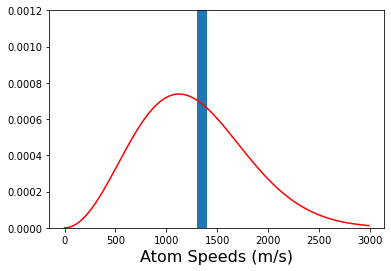

In [743]:
poss, vels = initialize_atoms()
speeds = np.sqrt(vels[:,0]**2 + vels[:,1]**2 + vels[:,2]**2)
plt.hist(speeds,bins=np.arange(0,3000,100),density=True)
plt.plot(vs,mb,'r-')
plt.ylim([0,0.0012]);
plt.xlabel('Atom Speeds (m/s)',fontsize=16)
print(np.sum(vels**2)/1e8)

0 13 [-0.01805169 -0.03908231  0.01001982] 0.0019536871976645227 0.0036
0 119 [0.02276679 0.02671289 0.03022609] 0.002145522005894062 0.0036
2 120 [ 0.01247298 -0.00284283 -0.05168912] 0.0028354221605420417 0.0036
2 138 [ 0.01876194 -0.01215905 -0.05216958] 0.0032215180531722063 0.0036
6 28 [ 0.05279073  0.00078348 -0.01822234] 0.0031195286572029035 0.0036
10 79 [-0.03902441  0.03751008  0.00110147] 0.0029311236525156313 0.0036
26 55 [-0.03509888  0.00331062 -0.0226368 ] 0.0017553167165472066 0.0036
26 121 [-0.01047648  0.04293239  0.02163417] 0.0024209836374072024 0.0036
32 177 [ 0.01148678 -0.00133006  0.03286557] 0.001213860635376339 0.0036
32 188 [-0.01982231 -0.00246891 -0.02473101] 0.001010642142663315 0.0036
42 49 [ 0.00323568 -0.04023978  0.00336641] 0.001641041994120639 0.0036
43 141 [-0.02038352 -0.03954001 -0.00846602] 0.0020505731793808747 0.0036
65 70 [0.03158996 0.0485207  0.00934739] 0.0034395573755059633 0.0036
75 102 [ 0.01242822 -0.02013465 -0.04175236] 0.002303124156

C:\Users\byecs\AppData\Local\Temp/ipykernel_27156/1416350437.py:24: RuntimeWarning: invalid value encountered in arcsin
  alpha    = np.arcsin(dy/(2*Ratom))


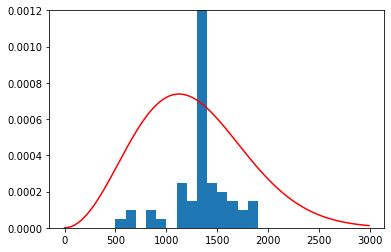

In [741]:
update_state(poss,vels)
speeds = np.sqrt(vels[:,0]**2 + vels[:,1]**2 + vels[:,2]**2)
plt.hist(speeds,bins=np.arange(0,3000,100),density=True);
plt.plot(vs,mb,'r-')
plt.ylim([0,0.0012]);
print(np.sum(vels**2)/1e8)

In [739]:
#for j in range(1000):
#    update_state(poss,vels)

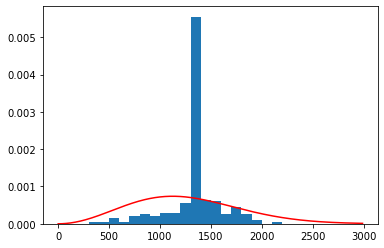

In [727]:
speeds = np.sqrt(vels[:,0]**2 + vels[:,1]**2 + vels[:,2]**2)
plt.hist(speeds,bins=np.arange(0,3000,100),density=True);
plt.plot(vs,mb,'r-')

In [651]:
pos_i = np.array([-0.17885164,0.37003664,-0.14497234])
pos_j = np.array([-0.15873083,0.387046,-0.08997407])
vel_i = np.array([784.85639558,-716.74783151,-1479.81280519])
vel_j = np.array([-421.36669504,146.34030685,-1303.07673408])

In [652]:
rrel = pos_i - pos_j

In [655]:
rrel.dot(rrel)

0.003718975025658602

In [656]:
4*Ratom**2

0.0036